In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import umap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer
from sklearn.cluster import KMeans
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [18]:
def optimize_UMAP_hyperparameters(feat_df, y_param, colors, s):
   n_neighbors_range = list(range(10, 110, 10))
   min_dist_range = np.arange(0.01, 0.5, 0.05)
  
   best_silhouette_score = -np.inf
   best_n_neighbors = None
   best_min_dist = None
    
   # grid search
   for n_neighbors in n_neighbors_range:
       for min_dist in min_dist_range:
           standardized_data = StandardScaler().fit_transform(feat_df)
           reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
           embedding = reducer.fit_transform(standardized_data)
           kmeans = KMeans(n_clusters=len(np.unique(y_param)),n_init='auto', random_state=42)
           kmeans.fit(embedding)
           silhouette_score_ = silhouette_score(embedding, kmeans.labels_)
           if silhouette_score_ > best_silhouette_score:
               best_silhouette_score = silhouette_score_
               best_n_neighbors = n_neighbors
               best_min_dist = min_dist
               best_embedding = embedding
   print(f"Best Silhouette Score: {best_silhouette_score}")
   print(f"Best n_neighbors: {best_n_neighbors}")
   print(f"Best min_dist: {best_min_dist}")
  
   embedding_df = pd.DataFrame(data=best_embedding, columns=['UMAP 1', 'UMAP 2'])
   finalDf = pd.concat([embedding_df, y_param.reset_index(drop=True)], axis=1)
   fig = plt.figure(figsize=(12, 12))
   ax = fig.add_subplot(1, 1, 1)
   ax.set_title('UMAP Clustering', fontsize=20)
   ax.grid(False)
   targets = np.unique(finalDf[y_param.name])
   for target, color in zip(targets, colors):
       indicesToKeep = finalDf[y_param.name] == target
       ax.scatter(finalDf.loc[indicesToKeep, 'UMAP 1'],
                  finalDf.loc[indicesToKeep, 'UMAP 2'],
                  c=color,
                  s=s)
   ax.legend(targets, loc='center left', bbox_to_anchor=(1, 0.5))
   plt.show()


In [22]:
def UMAP_maker(feat_df, y_param, colors, s, n_neighbors=40, min_dist=0.01, filter_func=None):
     standardized_data = StandardScaler().fit_transform(feat_df)
     reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2,  random_state=42)
     embedding = reducer.fit_transform(standardized_data)
     embedding_df = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])
     finalDf = pd.concat([embedding_df, y_param.reset_index(drop=True)], axis=1)
   
     if filter_func is not None:
       finalDf = finalDf[finalDf[y_param.name].isin(filter_func)]
   
     fig = plt.figure(figsize=(12,12))
     ax = fig.add_subplot(1,1,1)
     ax.set_title('UMAP ', fontsize=20)
     ax.grid(False)
     targets = np.unique(finalDf[y_param.name])
     for target, color in zip(targets, colors):
       indicesToKeep = finalDf[y_param.name] == target
       ax.scatter(finalDf.loc[indicesToKeep, 'UMAP 1'],
             finalDf.loc[indicesToKeep, 'UMAP 2'],
             c=color,
             s=s)

     ax.legend(targets, loc='center left', bbox_to_anchor=(1, 0.5))
     #plt.savefig('UMAP clustering based on Tumor type.png')

In [6]:
# definition of the creation of the y_param - used in transp_TSNE_plot
def create_y_param(lesion, tumor_list, binary_tumor):
    if lesion == 0:
        y = feature_df[feature_df['lesion_type'] == 0]
    elif lesion == 1:
        y = feature_df[feature_df['lesion_type'] != 0]
    elif lesion == 2:
        y = feature_df
    else:
        y = feature_df 
        
    if y['tumour_type3_y'].isin(tumor_list).any():
        y_param = y[y['tumour_type3_y'].isin(tumor_list)]
        y_param = y_param.dropna(subset='tumour_type3_y')
        y_param = y_param['tumour_type3_y']
    else: 
        if binary_tumor == 'Lung':
            y_param = y['binary lung']
        elif binary_tumor == 'CRC':
            y_param = y['binary CRC']
        elif binary_tumor == 'Sarcoma':
            y_param = y['binary Sarcoma']
        elif binary_tumor == 'Melanoma':
            y_param = y['binary Melanoma']
        elif binary_tumor == 'Ovary':
            y_param = y['binary Ovary']
        elif binary_tumor == 'prim-mets':
            y_param = y['binary primary metastasis']
        else:
            raise ValueError("Invalid binary_tumor value.")
    return y_param

In [3]:
def transp_UMAP_maker(feat_df, lesion, tumor_list, binary_tumor, colors, s, n_neighbors=40, min_dist=0.01):
   numeric_columns = feat_df.select_dtypes(include=np.number)
   feat_df = numeric_columns.dropna()
   standardized_data = StandardScaler().fit_transform(feat_df)
   reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2)
   embedding = reducer.fit_transform(standardized_data)
   embedding_df = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])
   y_param = create_y_param(lesion, tumor_list, binary_tumor)
   finalDf = pd.concat([embedding_df, y_param.reset_index(drop=True)], axis=1)

   fig = plt.figure(figsize=(12,12))
   ax = fig.add_subplot(1,1,1)
   ax.set_title('UMAP Clustering Primary tumor(0) vs. Metastasis(1)', fontsize=20)
   ax.grid(False)
   targets = y_param.value_counts(dropna=False).index.to_list()
   for target, color in zip(targets, colors):
       indicesToKeep = finalDf[y_param.name] == target
       ax.scatter(finalDf.loc[indicesToKeep, 'UMAP 1'],
                  finalDf.loc[indicesToKeep, 'UMAP 2'],
                  c=color,
                  s=s)
   ax.legend(targets, loc='center left', bbox_to_anchor=(1, 0.5))
  # plt.savefig('UMAP Clustering Primary tumor(0) vs. Metastasis(1).png')

In [4]:
colors = [
    '#00c853', # Green
    '#d50000', # Red
]

all_colors = [
    '#d50000', # Red
    '#00c853', # Green
    '#ff6d00', # Orange
    '#2962ff', # Blue
    "#FFE119", # Yellow
    "#46F0F0", # Cyan
    '#6200ea', # Deep Purple
    '#c51162', # Pink
    '#aeea00', # Lime
    '#2196f3', # Blue 2
    '#304ffe', # Indigo
    '#aa00ff', # Purple
    '#263238', # Blue Grey
    '#00b8d4', # Cyan
    '#ffab00', # Amber 
    '#9e9e9e', # Grey 2
    '#ffc107', # Golden
    '#00bcd4', # Cyan 2
    '#00bfa5', # Teal
    '#ff6d00', # Orange
    '#dd2c00', # Deep Orange
    '#212121', # Grey
    '#9c27b0', # Purple 2
    '#ff5722', # Orange 2
    '#4caf50', # Green 2
    '#c51162', # Pink
    '#00bfa5', # Teal
    '#64dd17', # Light Green
    '#f44336', # Red 2
    '#795548', # Brown 2
    '#607d8b', # Blue Grey 2
    '#e91e63', # Pink 2

]

nine_colors = [
    '#d50000', # Red
    '#00c853', # Green
    '#ff6d00', # Orange
    '#2962ff', # Blue
    '#3e2723', # Brown
    '#0091ea', # Light Blue
    '#6200ea', # Deep Purple
    '#c51162', # Pink
    '#aeea00', # Lime

]

## Importing Datasets

In [5]:
# import clinical df 
clinical_df = pd.read_excel(r"C:\Users\m.soliman\Downloads\Clinical\PANCANCER_clin_v3.xlsx")

In [6]:
feature_df = pd.read_csv(r"C:\Users\m.soliman\Downloads\Radiomics\20230921_PANCANCER_radiomics.csv")

In [7]:
feature_df =feature_df.drop(feature_df.columns[[0, 1, 9, 10, 11, 12, 13, 14,15, -1]], axis =1)

In [8]:
feature_df = pd.merge(feature_df, clinical_df[['Scan_Name', 'tumtype']], on="Scan_Name", how='left')

## Pre-Processing

In [9]:
def classify_segment(segment):
   if segment==0:
       return 'Primary'
   elif segment==1:
       return 'Lymph Nodes'
   elif segment==2:
       return 'Lung mets'
   elif segment==3:
       return 'Liver mets'
   elif segment==4:
       return 'Abdopelvis mets'
   elif segment==5:
       return 'Bone mets'
   elif segment==6:
       return 'Brain mets'
   elif segment==7:
       return 'Adrenal mets'
   else:
       return 'Others'

In [10]:
feature_df['lesion_type'] = feature_df['Segment Name'].astype(str).str[0].astype(int)
categories = ['CRC', 'Sarcoma', 'melanoma', 'ovary', 'lung']
feature_df['categories']= feature_df['tumtype'].apply(lambda x: x if x in categories else 'none')
one_hot_encoded_df = pd.get_dummies(feature_df['categories'], prefix='tumtype').astype(int)
names = {
    'tumtype_CRC':'binary CRC',
    'tumtype_Sarcoma':'binary Sarcoma',
    'tumtype_melanoma':'binary Melanoma',
    'tumtype_ovary':'binary Ovary',
    'tumtype_lung':'binary lung',}
one_hot_encoded_df.rename(columns=names, inplace=True)
one_hot_encoded_df = one_hot_encoded_df.drop('tumtype_none', axis=1)
feature_df = pd.concat([feature_df, one_hot_encoded_df], axis=1)
feature_df = feature_df.rename(columns={'tumtype': 'tumour_type3_y'})
feature_df = feature_df.drop('categories', axis=1)
feature_df['binary p  rimary metastasis'] = (~feature_df['Segment Name'].astype(str).apply(lambda x: x.startswith('0'))).astype(int)
feature_df['Location'] = feature_df['lesion_type'].apply(classify_segment)
feature_df['binary lymph nodes']= (feature_df['Location']=='Lymph Nodes').astype(int)

In [11]:
feature_df

,Scan_Name,Segment ID,Segment Name,Segment index,Label,Label_channel,Dimensionality,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,lbp-3D-k_ngtdm_Strength,tumour_type3_y,lesion_type,binary CRC,binary Sarcoma,binary lung,binary Ovary,binary p rimary metastasis,Location,binary lymph nodes
0,PANCANCER_0003,Segment_1,0.1,0,1,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.047564,lung,0,0,0,1,0,0,Primary,0
1,PANCANCER_0003,Segment_2,1.1,1,2,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.048207,lung,1,0,0,1,0,1,Lymph Nodes,1
2,PANCANCER_0003,Segment_3,1.2,2,3,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.065413,lung,1,0,0,1,0,1,Lymph Nodes,1
3,PANCANCER_0003,Segment_4,2.1,3,4,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.184482,lung,2,0,0,1,0,1,Lung mets,0
4,PANCANCER_0003,Segment_5,2.2,4,5,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",7aa630b85deda100e6b454ed984f95effa8ed1ba,...,0.164960,lung,2,0,0,1,0,1,Lung mets,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11163,PANCANCER_1813,Segment_3,3.3,2,3,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",06ec93b113a873cac6167dd38c09fcf44a8bd8c4,...,0.143187,CRC,3,1,0,0,0,1,Liver mets,0
11164,PANCANCER_1814,Segment_1,0.1,0,1,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",b3048f3e6dcb472b05ae1694c0045e521c3b0b65,...,0.033966,lung,0,0,0,1,0,0,Primary,0
11165,PANCANCER_1814,Segment_2,3.1,1,2,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",b3048f3e6dcb472b05ae1694c0045e521c3b0b65,...,0.029939,lung,3,0,0,1,0,1,Liver mets,0
11166,PANCANCER_1815,Segment_1,0.1,0,1,0,3D,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {'binWidth': 5.0}, 'Square': {'bi...",6b828b44b16ba0a9e1fb95f132c542dbb2c1984b,...,0.001257,Sarcoma,0,0,1,0,0,0,Primary,0


## Defining tumor df and y param

In [12]:
x_start = feature_df.columns.get_loc('original_shape_Elongation')
x_end = feature_df.columns.get_loc('lbp-3D-k_ngtdm_Strength')+1

In [13]:
# definition of all tumors df 
all_df = feature_df.dropna(subset='tumour_type3_y')
all_df = all_df.iloc[:, x_start:x_end].fillna(all_df.median(numeric_only=True))


In [14]:
# definition of primary df and y_param 
primary_df = feature_df[feature_df['lesion_type'] == 0]
primary_df = primary_df.dropna(subset='tumour_type3_y')
primary_feat_df = primary_df.iloc[:, x_start:x_end].fillna(feature_df.median(numeric_only=True))
primary_outcome_name = 'Tumour_Type'

primary_y_param = primary_df['tumour_type3_y']
primary_lung_y_param = primary_df['binary lung']
primary_CRC_y_param = primary_df['binary CRC']
lesion_y_param = feature_df['lesion_type']

In [15]:
# used feat_df = all_df 
# y_param = 
patient_level_y_param = feature_df['tumour_type3_y']
Location_y_param = feature_df['Location']

## Clustering based on Tumor Type

C:\Users\m.soliman\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


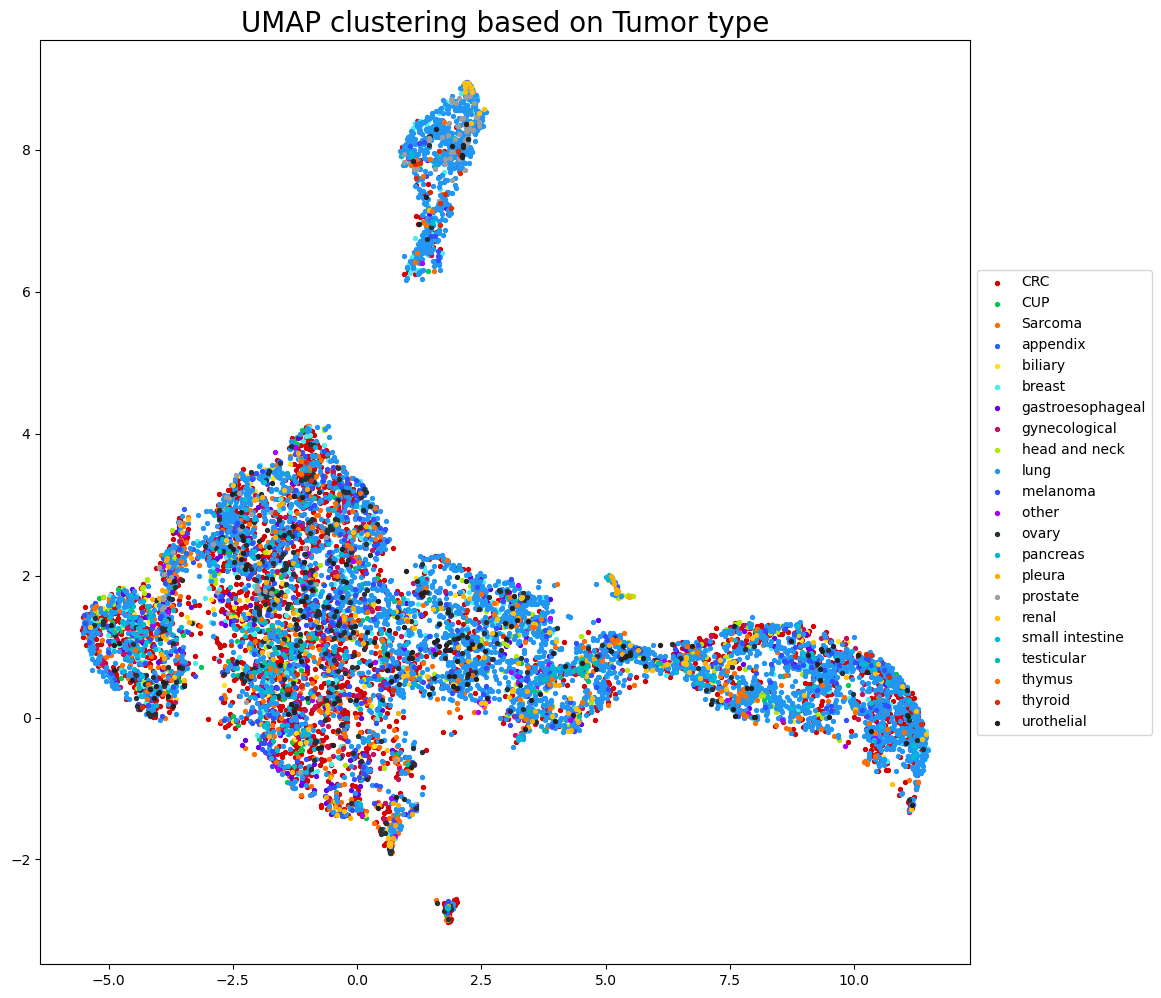

In [96]:
UMAP_maker(feat_df=all_df, y_param=patient_level_y_param, colors=all_colors, s=8)

Best Silhouette Score: 0.4282621741294861
Best n_neighbors: 40
Best min_dist: 0.01


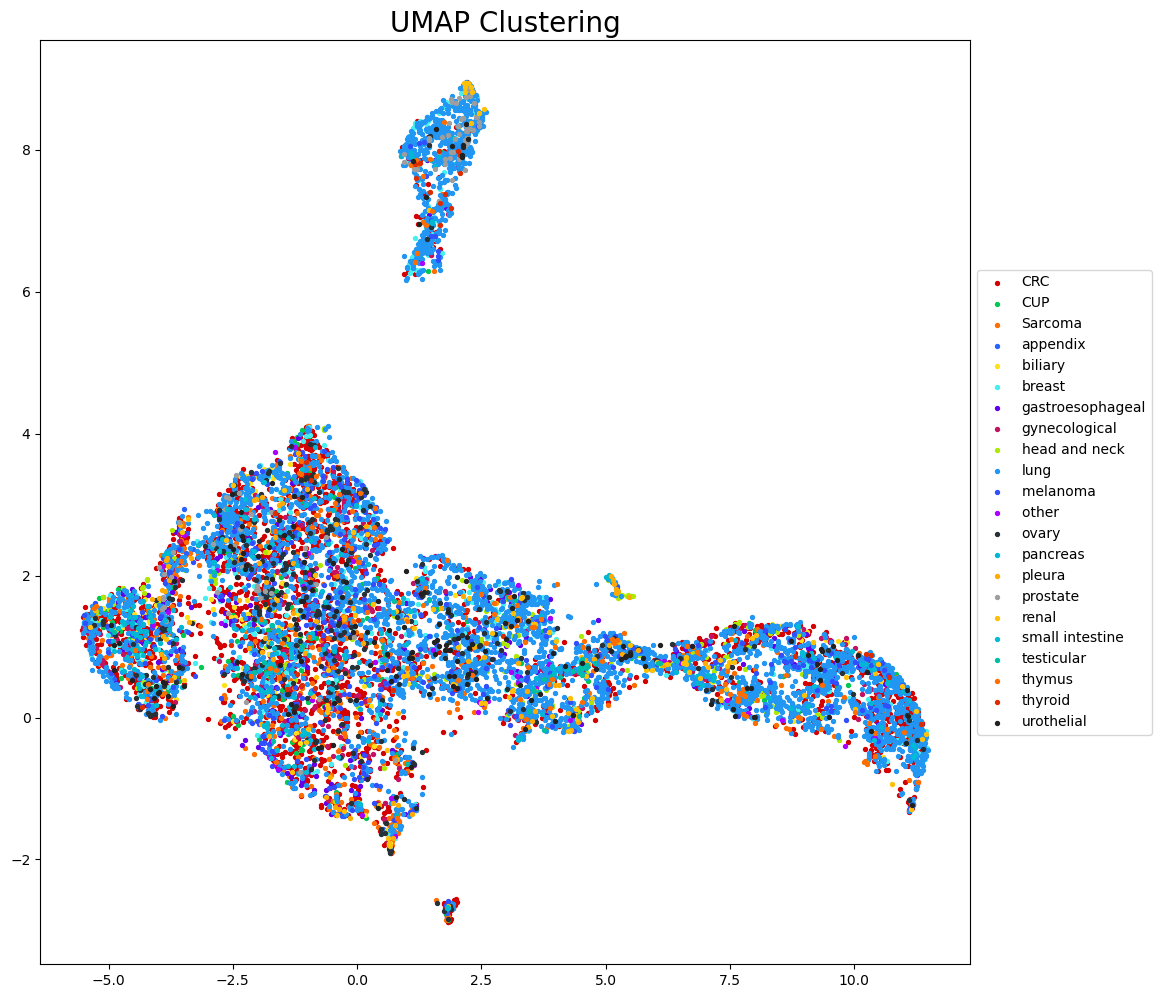

In [19]:
optimize_UMAP_hyperparameters(feat_df=all_df, y_param=patient_level_y_param, colors=all_colors, s=8)

In [19]:
## Step 1.1: 5 most common tumor types with patient level(diagnosis) label 

## Clustering based on 5 most common Tumor Types

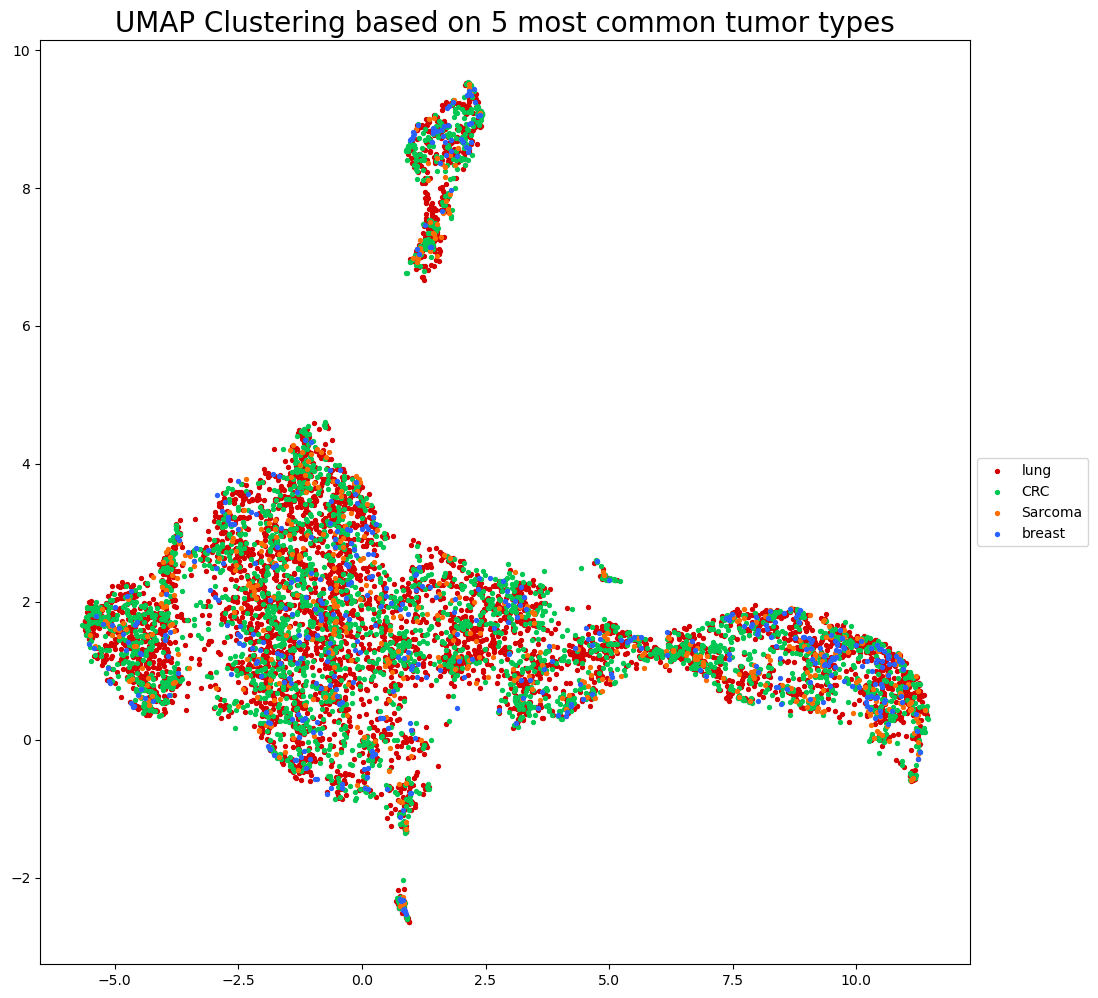

In [65]:
transp_UMAP_maker(feat_df=all_df, lesion=2, tumor_list=['lung', 'CRC', 'Sarcoma', 'breast', 'melanoma'], binary_tumor='none', colors=all_colors, s=8)

## Clustering of Primary vs. Mets

In [21]:
## Step 1.2: patient level labels of all tumor types - applying to lesion it applies to - primary vs mets 

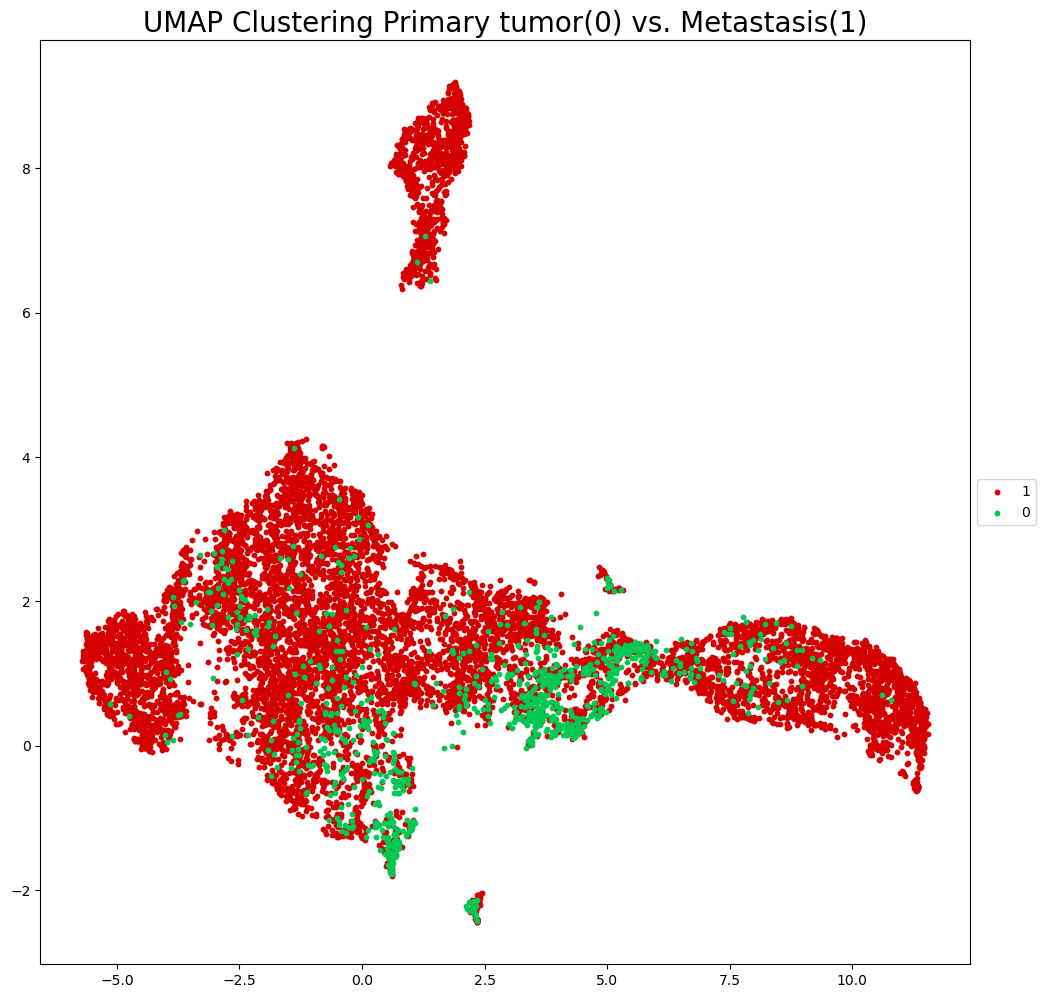

In [97]:
transp_UMAP_maker(feat_df=all_df, lesion=2, tumor_list=['none'], binary_tumor='prim-mets', colors=all_colors, s=10)

## Clustering of only Primary Tumors

Best Silhouette Score: 0.4718201458454132
Best n_neighbors: 20
Best min_dist: 0.01


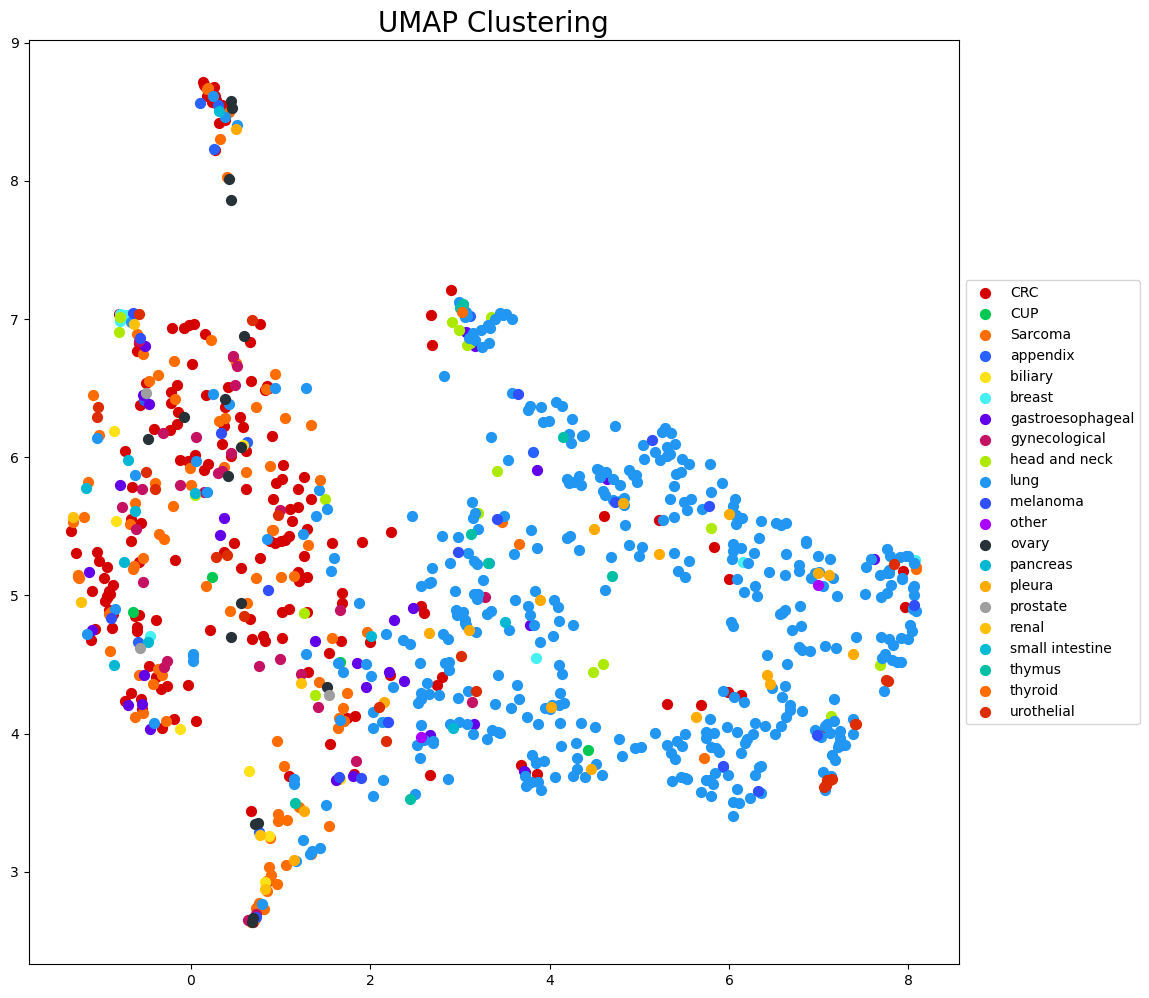

In [21]:
optimize_UMAP_hyperparameters(feat_df=primary_feat_df, y_param=primary_y_param, colors=all_colors, s=50)

In [24]:
## Step 2: patient level applied to according lesion - only primary lesions 
# feat_df = df with only primary lesions 
# y_param = tumor types 

C:\Users\m.soliman\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


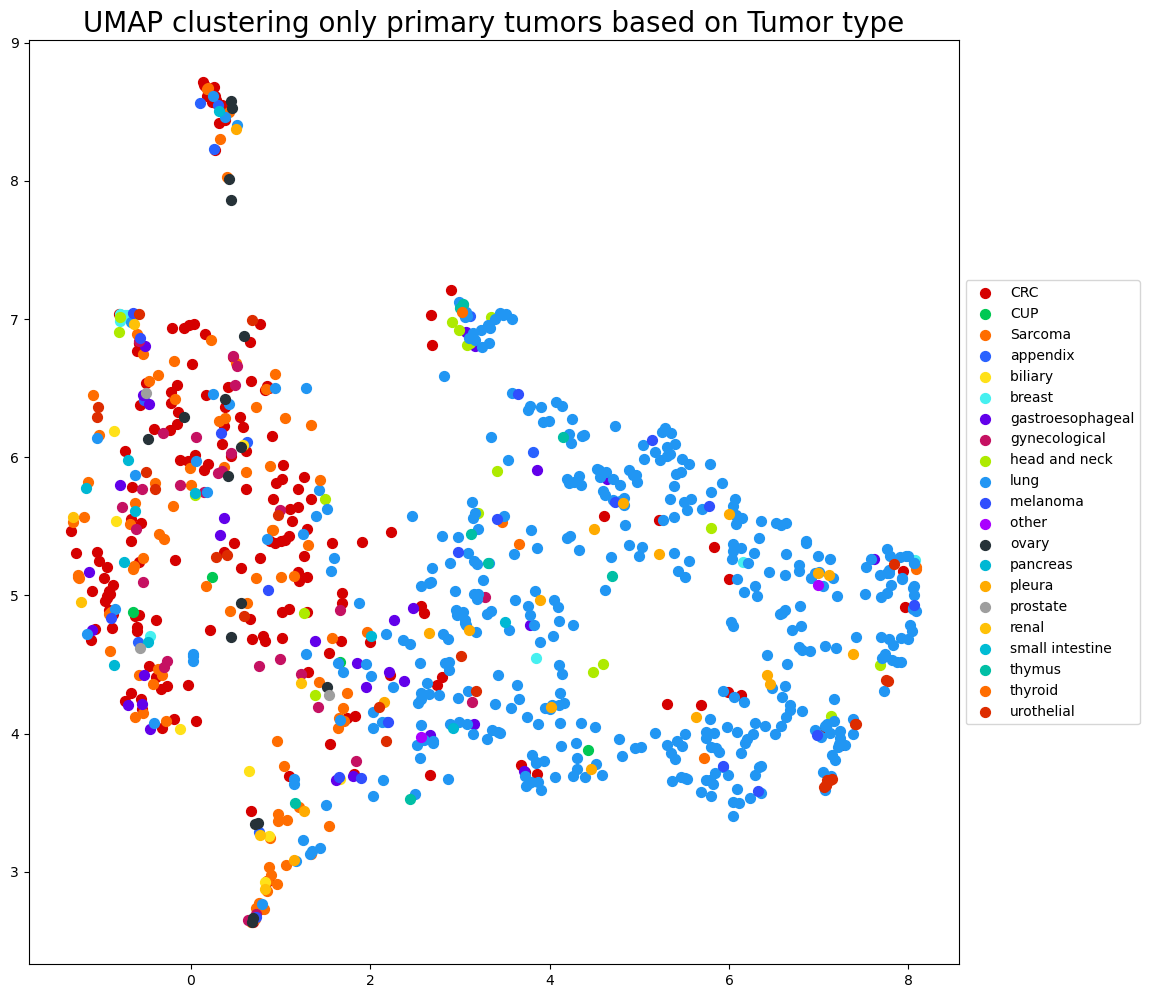

In [86]:
UMAP_maker(feat_df=primary_feat_df, y_param=primary_y_param, colors=all_colors, s=50)

### Clustering of only primary tumors - Lung vs. Non-Lung

C:\Users\m.soliman\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


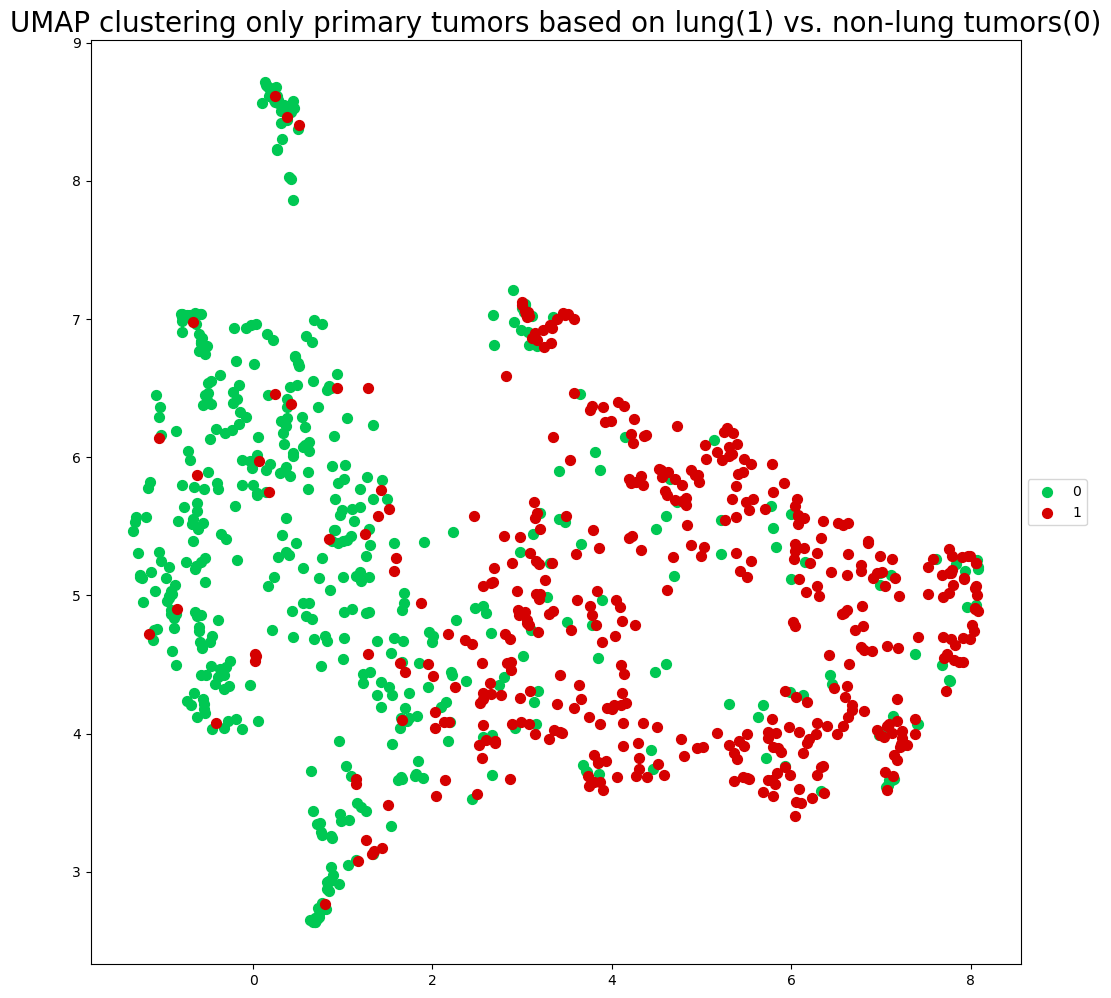

In [88]:
# Step 2.1: Primary - lung vs everything else 
UMAP_maker(feat_df=primary_feat_df, y_param=primary_lung_y_param, colors=colors, s=50)

### Clustering of only primary tumors - CRC vs. Non-CRC

C:\Users\m.soliman\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


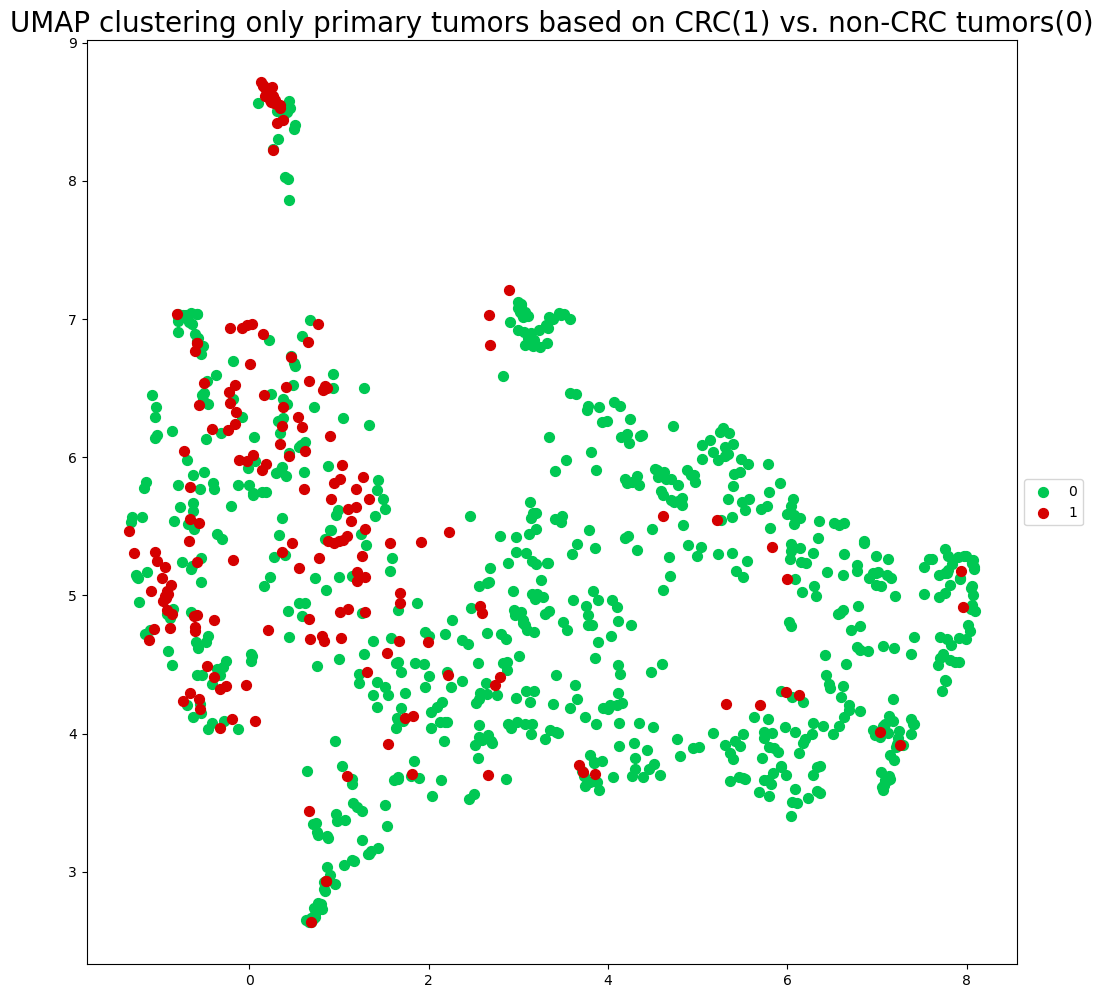

In [90]:
# Step 2.1: Primary - lung vs everything else 
UMAP_maker(feat_df=primary_feat_df, y_param=primary_CRC_y_param, colors=colors, s=50)

## Clustering based on anatomical location 

### All lesions

In [27]:
## Step 3: on a lesion level 
# feat_df = df with all lesions and tumor types 
# y_param = lesion types 

Best Silhouette Score: 0.49399545788764954
Best n_neighbors: 40
Best min_dist: 0.01


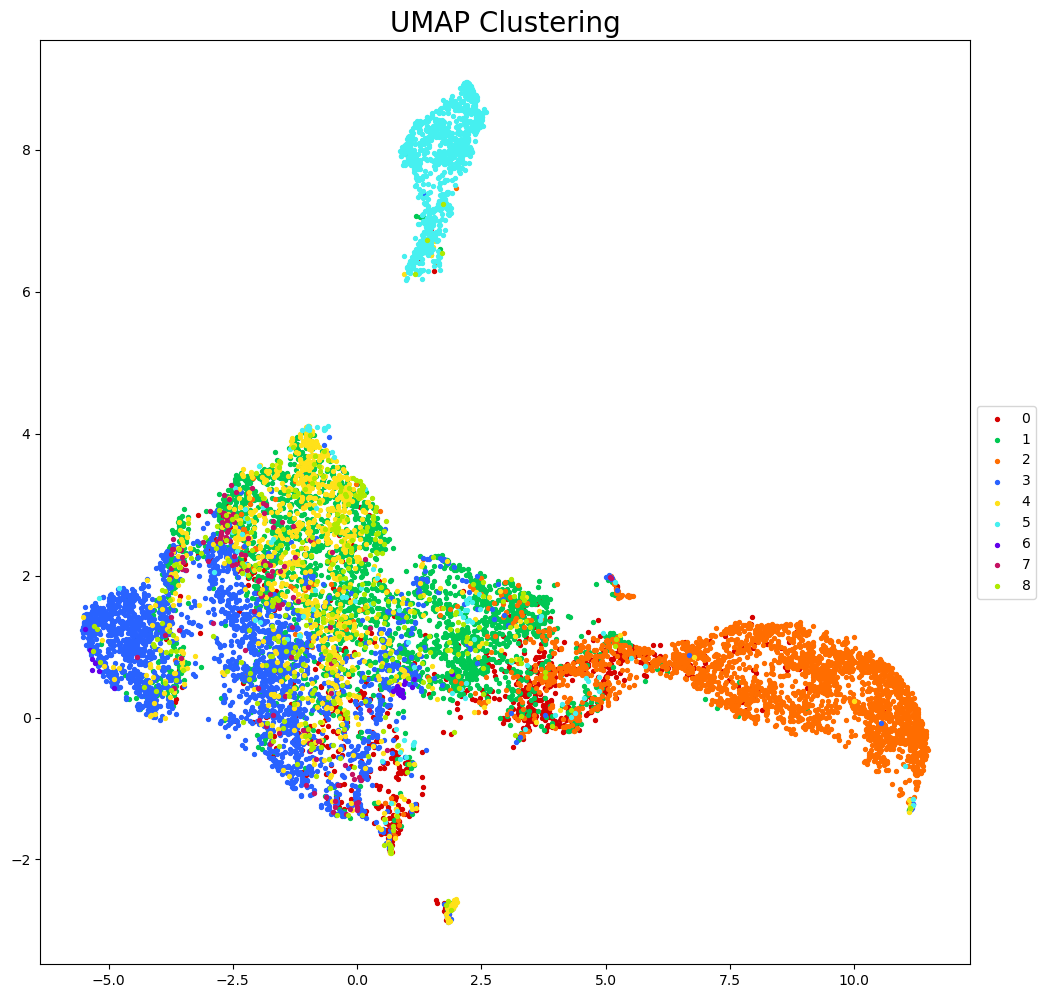

In [20]:
optimize_UMAP_hyperparameters(feat_df=all_df, y_param=lesion_y_param, colors=all_colors, s=8)

C:\Users\m.soliman\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


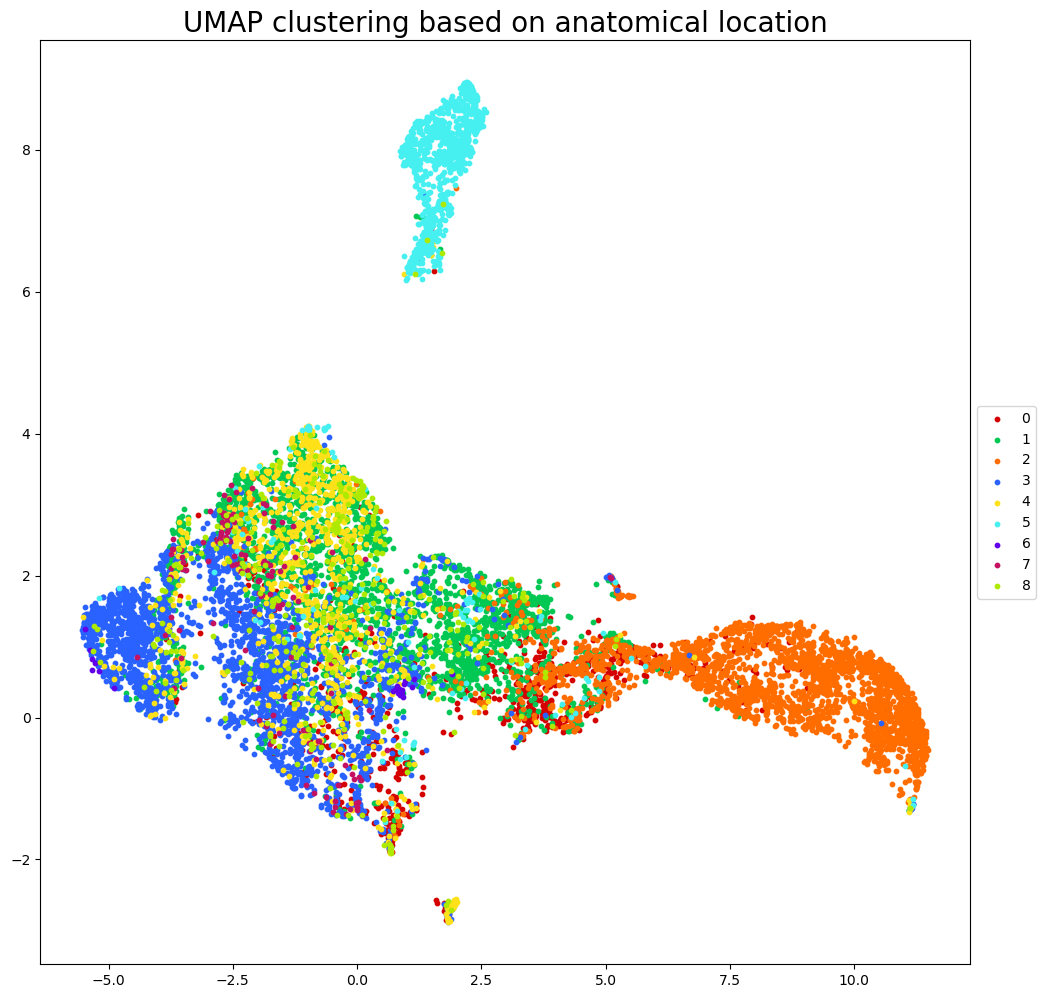

In [94]:
UMAP_maker(feat_df=all_df, y_param=lesion_y_param, colors=all_colors, s=10)

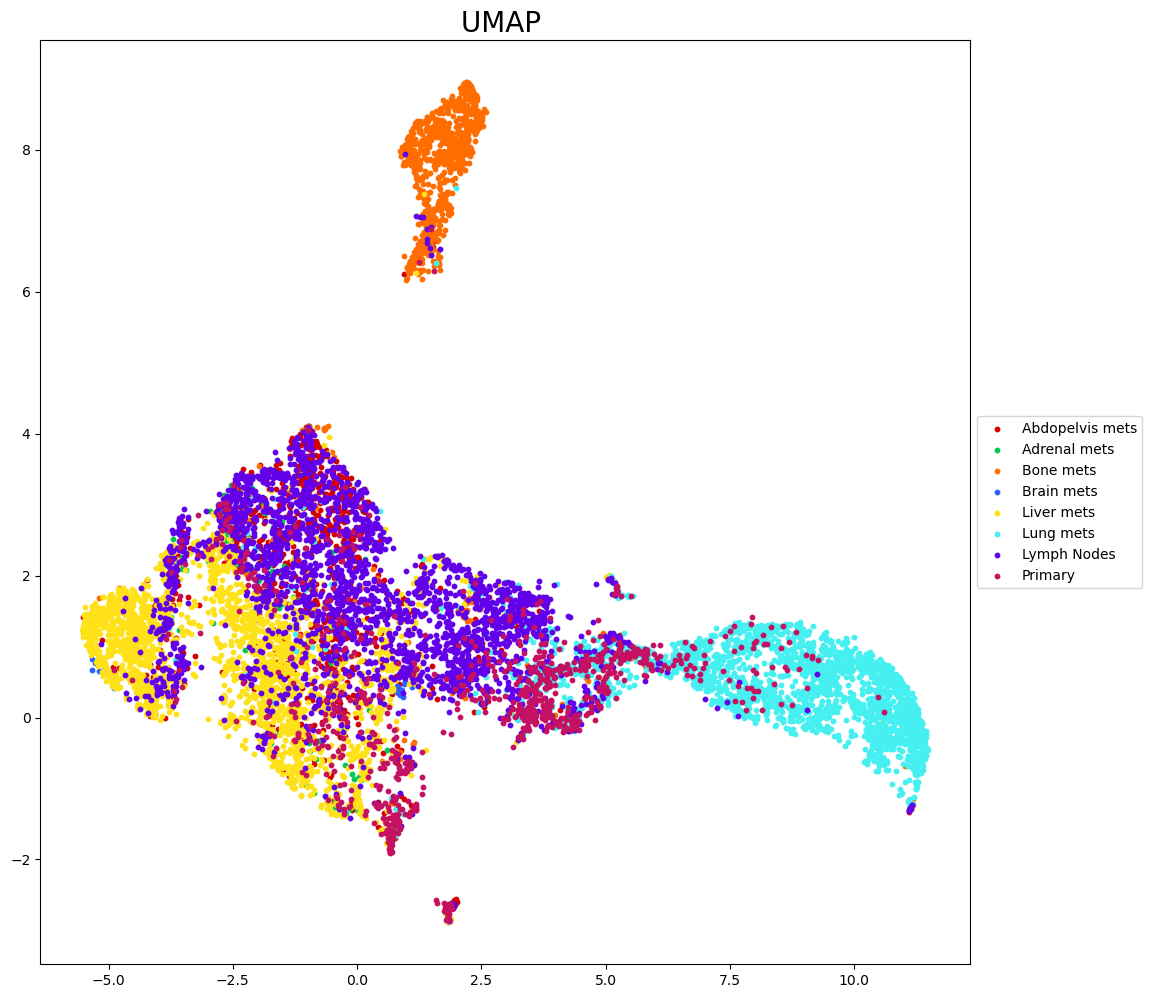

In [23]:
UMAP_maker(feat_df=all_df, y_param=Location_y_param, colors=all_colors, s=10, filter_func=['Primary', 'Lymph Nodes', 'Lung mets', 'Liver mets', 'Bone mets', 'Adrenal mets', 'Abdopelvis mets', 'Brain mets'])